# 03. Evaluation and Explainability

## Objectives
1. **Comprehensive Evaluation**: Test all models on held-out test set
2. **Visual Analysis**: ROC curves, PR curves, confusion matrices
3. **Model Explainability**: Feature importance, coefficients, SHAP values
4. **Error Analysis**: Deep dive into false positives and false negatives
5. **Business Justification**: Recommendations for deployment

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, average_precision_score
)

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load Data and Models

In [2]:
DATA_DIR = '../data/'
MODEL_DIR = '../reports/'

# Load test data
X_test = pd.read_csv(DATA_DIR + 'X_test_scaled.csv')
y_test = pd.read_csv(DATA_DIR + 'y_test.csv').values.ravel()
feature_names = pd.read_csv(DATA_DIR + 'feature_names.csv')['Feature'].tolist()

print(f"Test set shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Test set fraud rate: {y_test.mean() * 100:.2f}%")

# Load trained models
lr_model = joblib.load(MODEL_DIR + 'lr_model.pkl')
rf_model = joblib.load(MODEL_DIR + 'rf_model.pkl')
xgb_model = joblib.load(MODEL_DIR + 'xgb_model.pkl')

models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

print("\n✓ Models loaded successfully")

Test set shape: (1082, 68)
Number of features: 68
Test set fraud rate: 9.33%



✓ Models loaded successfully


## 2. Model Evaluation on Test Set

In [3]:
# Evaluate all models
evaluation_results = []

print("="*80)
print("TEST SET EVALUATION")
print("="*80)

# Convert X_test to NumPy for all models (especially XGBoost)
X_test_np = X_test.to_numpy() if hasattr(X_test, "to_numpy") else X_test

for name, model in models.items():
    # Predictions (XGBoost FAILS on DataFrame → use NumPy)
    y_pred = model.predict(X_test_np)
    y_prob = model.predict_proba(X_test_np)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    
    evaluation_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    print(f"  PR-AUC:    {pr_auc:.4f}")

# Create comparison DataFrame
eval_df = pd.DataFrame(evaluation_results)
print("\n" + "="*80)
print("\nCOMPARISON TABLE:")
print(eval_df.to_string(index=False))


TEST SET EVALUATION

Logistic Regression:
  Accuracy:  0.8983
  Precision: 0.4767
  Recall:    0.9109
  F1 Score:  0.6259
  ROC-AUC:   0.9683
  PR-AUC:    0.7842



Random Forest:
  Accuracy:  0.9353
  Precision: 0.6281
  Recall:    0.7525
  F1 Score:  0.6847
  ROC-AUC:   0.9673
  PR-AUC:    0.7639

XGBoost:
  Accuracy:  0.9372
  Precision: 0.6460
  Recall:    0.7228
  F1 Score:  0.6822
  ROC-AUC:   0.9608
  PR-AUC:    0.7949


COMPARISON TABLE:
              Model  Accuracy  Precision   Recall       F1  ROC_AUC   PR_AUC
Logistic Regression  0.898336   0.476684 0.910891 0.625850 0.968349 0.784207
      Random Forest  0.935305   0.628099 0.752475 0.684685 0.967299 0.763933
            XGBoost  0.937153   0.646018 0.722772 0.682243 0.960769 0.794872


## 3. Confusion Matrices

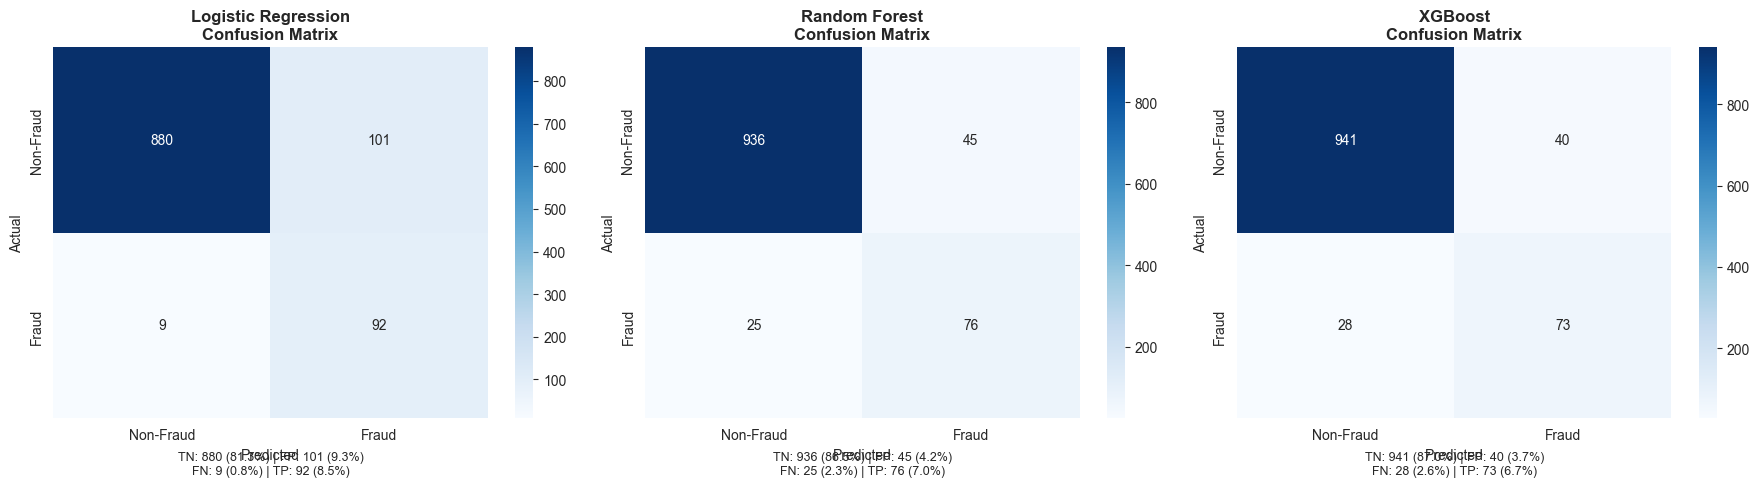

In [4]:
# Convert X_test to NumPy for XGBoost compatibility
X_test_np = X_test.to_numpy() if hasattr(X_test, "to_numpy") else X_test

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model) in enumerate(models.items()):
    # Use NumPy input for ALL models to avoid pandas.Int64Index bugs
    y_pred = model.predict(X_test_np)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'])
    
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')
    
    # Add TN, FP, FN, TP percentages
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    axes[idx].text(
        0.5, -0.15,
        f'TN: {tn} ({tn/total*100:.1f}%) | FP: {fp} ({fp/total*100:.1f}%)\n'
        f'FN: {fn} ({fn/total*100:.1f}%) | TP: {tp} ({tp/total*100:.1f}%)',
        ha='center', transform=axes[idx].transAxes, fontsize=9
    )

plt.tight_layout()
plt.show()


## 4. ROC and Precision-Recall Curves

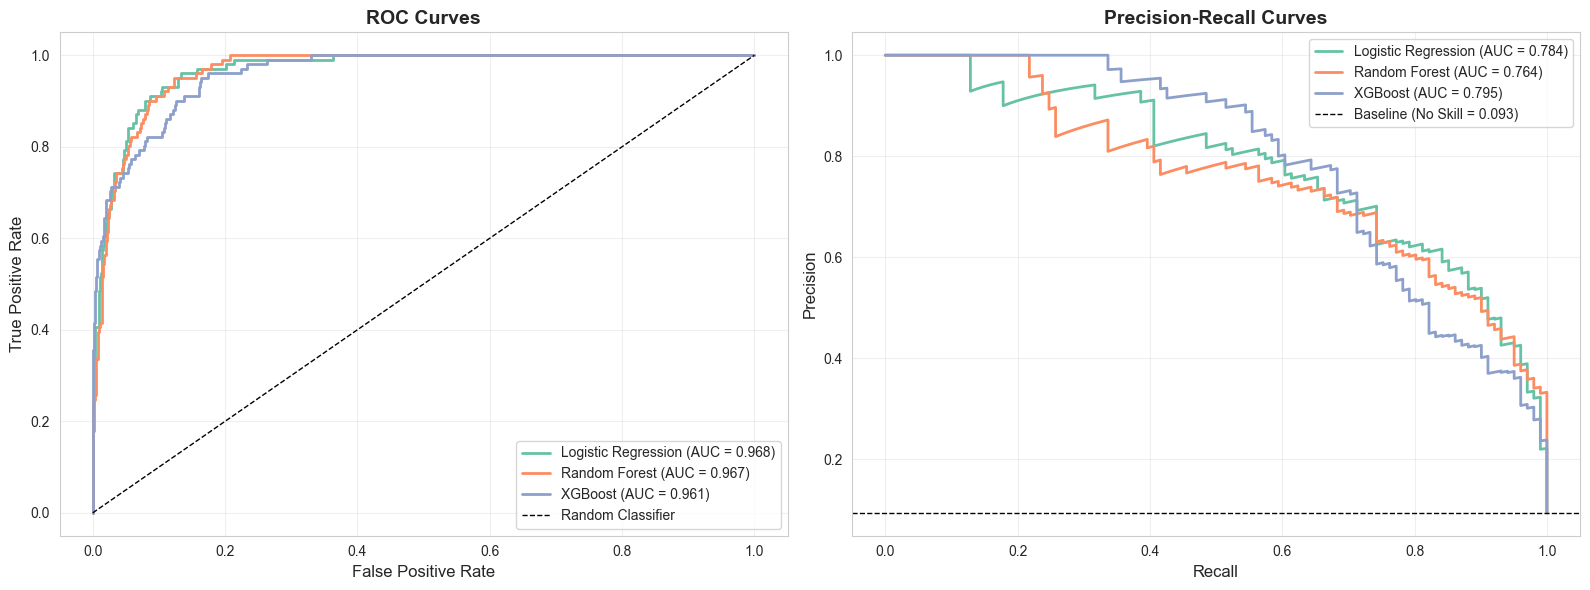

In [5]:
# Convert test data to NumPy for XGBoost compatibility
X_test_np = X_test.to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#66c2a5', '#fc8d62', '#8da0cb']

for idx, (name, model) in enumerate(models.items()):
    # Use NumPy input for ALL models
    y_prob = model.predict_proba(X_test_np)[:, 1]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})',
                 color=colors[idx], linewidth=2)
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    axes[1].plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})',
                 color=colors[idx], linewidth=2)

# ROC Curve formatting
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# PR Curve formatting
baseline = y_test.mean()
axes[1].axhline(y=baseline, color='k', linestyle='--', linewidth=1,
                label=f'Baseline (No Skill = {baseline:.3f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Model Explainability

### 5.1 Logistic Regression Coefficients

LOGISTIC REGRESSION COEFFICIENTS

Top 10 Positive Coefficients (Fraud Indicators):
                             Feature  Coefficient
          Inpatient_NumDiagnoses_max     1.302645
     Inpatient_DeductibleAmtPaid_sum     1.242466
         Inpatient_ClaimDuration_max     1.088320
Inpatient_InscClaimAmtReimbursed_sum     1.030732
                        Total_Claims     0.910308
                 Total_Reimbursement     0.899484
            Outpatient_ClaimID_count     0.893619
          Inpatient_LengthOfStay_max     0.780310
         Avg_Reimbursement_Per_Claim     0.381099
             Inpatient_ClaimID_count     0.366649

Top 10 Negative Coefficients (Non-Fraud Indicators):
                                 Feature  Coefficient
    Inpatient_OperatingPhysician_nunique    -0.166864
  Outpatient_InscClaimAmtReimbursed_mean    -0.206211
    Outpatient_ChronicCond_Diabetes_mean    -0.226289
               Outpatient_BeneID_nunique    -0.269810
Inpatient_ChronicCond_KidneyDisease_mean   

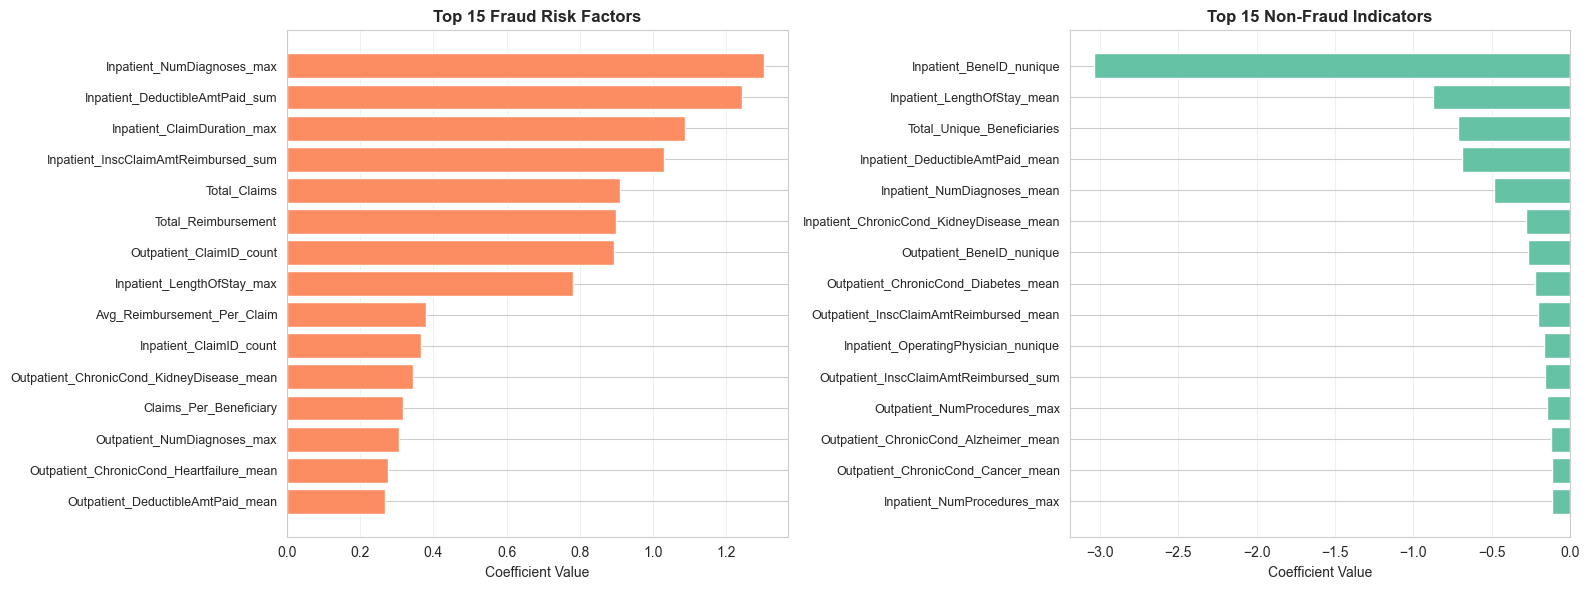

In [6]:
# Extract coefficients
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', ascending=False)

print("LOGISTIC REGRESSION COEFFICIENTS")
print("="*80)
print("\nTop 10 Positive Coefficients (Fraud Indicators):")
print(coefficients.head(10).to_string(index=False))
print("\nTop 10 Negative Coefficients (Non-Fraud Indicators):")
print(coefficients.tail(10).to_string(index=False))

# Visualize top coefficients
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top positive
top_pos = coefficients.head(15)
axes[0].barh(range(len(top_pos)), top_pos['Coefficient'], color='#fc8d62')
axes[0].set_yticks(range(len(top_pos)))
axes[0].set_yticklabels(top_pos['Feature'], fontsize=9)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title('Top 15 Fraud Risk Factors', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Top negative
top_neg = coefficients.tail(15).sort_values('Coefficient')
axes[1].barh(range(len(top_neg)), top_neg['Coefficient'], color='#66c2a5')
axes[1].set_yticks(range(len(top_neg)))
axes[1].set_yticklabels(top_neg['Feature'], fontsize=9)
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('Top 15 Non-Fraud Indicators', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 5.2 Random Forest Feature Importance

RANDOM FOREST FEATURE IMPORTANCE

Top 20 Most Important Features:
                              Feature  Importance
                  Total_Reimbursement    0.089407
           Inpatient_LengthOfStay_max    0.075273
              Inpatient_ClaimID_count    0.067177
          Inpatient_ClaimDuration_max    0.066330
 Inpatient_InscClaimAmtReimbursed_sum    0.053345
 Inpatient_InscClaimAmtReimbursed_max    0.052389
             Inpatient_BeneID_nunique    0.031765
         Inpatient_ClaimDuration_mean    0.027219
     Outpatient_DeductibleAmtPaid_sum    0.027033
             Outpatient_ClaimID_count    0.025007
                         Total_Claims    0.024801
          Inpatient_LengthOfStay_mean    0.021532
               Claims_Per_Beneficiary    0.021188
Outpatient_InscClaimAmtReimbursed_sum    0.019974
            Outpatient_BeneID_nunique    0.018935
          Inpatient_NumProcedures_max    0.018397
Inpatient_InscClaimAmtReimbursed_mean    0.018092
      Inpatient_DeductibleAmtPaid_

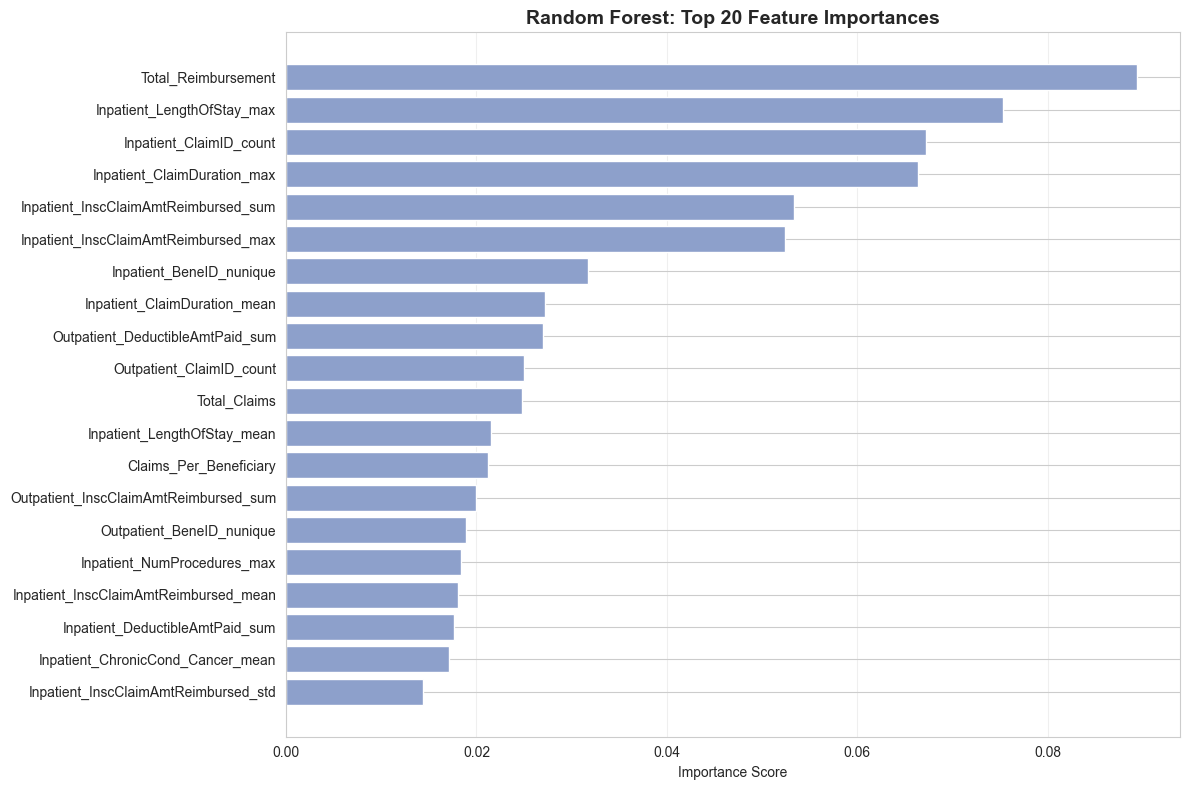

In [7]:
# Extract feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("RANDOM FOREST FEATURE IMPORTANCE")
print("="*80)
print("\nTop 20 Most Important Features:")
print(rf_importance.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_20 = rf_importance.head(20)
plt.barh(range(len(top_20)), top_20['Importance'], color='#8da0cb')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance Score')
plt.title('Random Forest: Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 5.3 XGBoost Feature Importance

XGBOOST FEATURE IMPORTANCE

Top 20 Most Important Features:
                                        Feature  Importance
                            Total_Reimbursement    0.263417
                    Inpatient_ClaimDuration_max    0.050715
          Outpatient_InscClaimAmtReimbursed_sum    0.030956
                                   Total_Claims    0.023934
                         Claims_Per_Beneficiary    0.022040
                Inpatient_DeductibleAmtPaid_sum    0.018099
                    Outpatient_NumDiagnoses_max    0.017967
          Outpatient_InscClaimAmtReimbursed_max    0.017066
             Outpatient_ChronicCond_Cancer_mean    0.014550
           Outpatient_ChronicCond_Diabetes_mean    0.014292
                  Outpatient_ClaimDuration_mean    0.014163
          Outpatient_InscClaimAmtReimbursed_std    0.013713
                      Outpatient_BeneID_nunique    0.013060
Outpatient_ChronicCond_rheumatoidarthritis_mean    0.013060
                        Inpatient_ClaimI

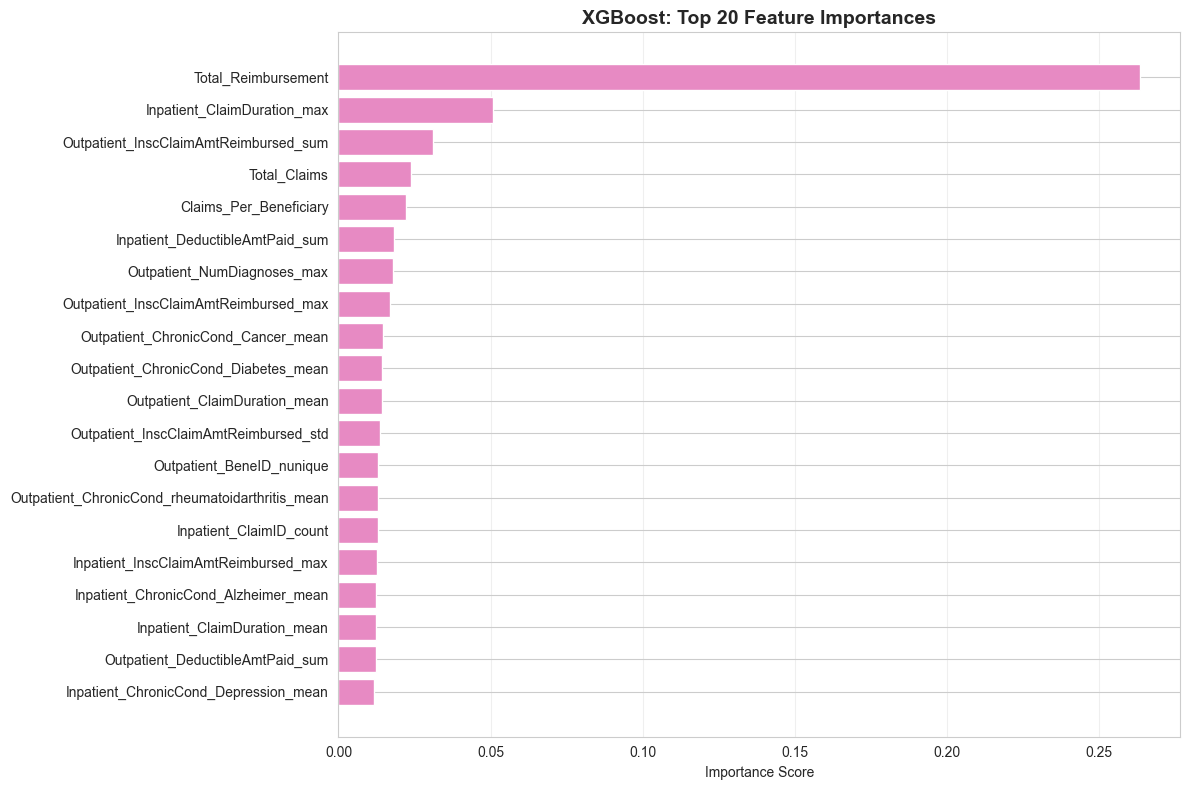

In [8]:
# Extract feature importance
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("XGBOOST FEATURE IMPORTANCE")
print("="*80)
print("\nTop 20 Most Important Features:")
print(xgb_importance.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_20 = xgb_importance.head(20)
plt.barh(range(len(top_20)), top_20['Importance'], color='#e78ac3')
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance Score')
plt.title('XGBoost: Top 20 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### 5.4 SHAP Analysis (XGBoost)

In [9]:
import shap

print("Computing SHAP values using KernelExplainer (slow but compatible)...")

# Convert test set to NumPy
X_np = X_test.to_numpy()

# Use a subset OF X_TEST as background (valid & works)
background = shap.sample(X_test, 100).to_numpy()

# KernelExplainer works with any model
explainer = shap.KernelExplainer(
    lambda x: xgb_model.predict_proba(x)[:, 1],
    background
)

# Compute SHAP values for a subset (KernelExplainer is slow)
shap_values = explainer.shap_values(X_np[:200])

print("✓ SHAP values computed")


Computing SHAP values using KernelExplainer (slow but compatible)...


  0%|          | 0/200 [00:00<?, ?it/s]

✓ SHAP values computed


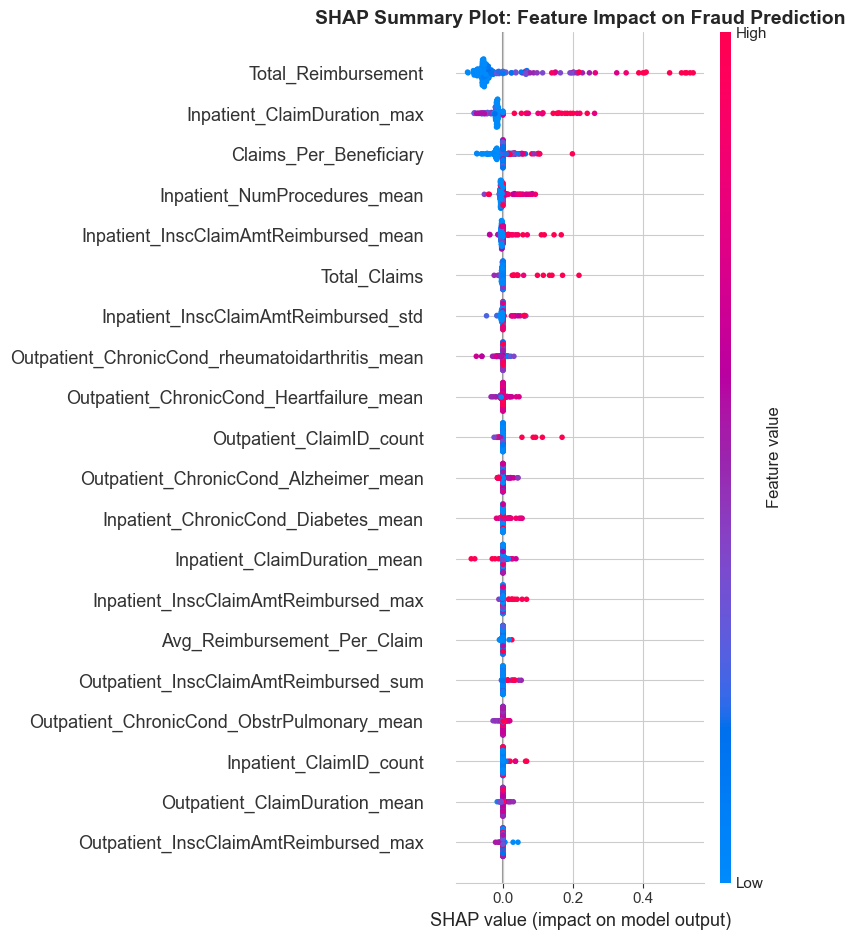

In [10]:
# Match SHAP rows (we computed SHAP for only the first N rows)
N = len(shap_values)

X_test_subset = X_test.iloc[:N]

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_test_subset,
    feature_names=feature_names,
    show=False
)
plt.title('SHAP Summary Plot: Feature Impact on Fraud Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



SHAP-based Feature Importance:
                                        Feature  SHAP_Importance
                            Total_Reimbursement         0.086943
                    Inpatient_ClaimDuration_max         0.035875
                         Claims_Per_Beneficiary         0.019005
                   Inpatient_NumProcedures_mean         0.009947
          Inpatient_InscClaimAmtReimbursed_mean         0.007737
                                   Total_Claims         0.007161
           Inpatient_InscClaimAmtReimbursed_std         0.004909
Outpatient_ChronicCond_rheumatoidarthritis_mean         0.004017
       Outpatient_ChronicCond_Heartfailure_mean         0.003581
                       Outpatient_ClaimID_count         0.003263
          Outpatient_ChronicCond_Alzheimer_mean         0.002842
            Inpatient_ChronicCond_Diabetes_mean         0.002789
                   Inpatient_ClaimDuration_mean         0.002610
           Inpatient_InscClaimAmtReimbursed_max         0.

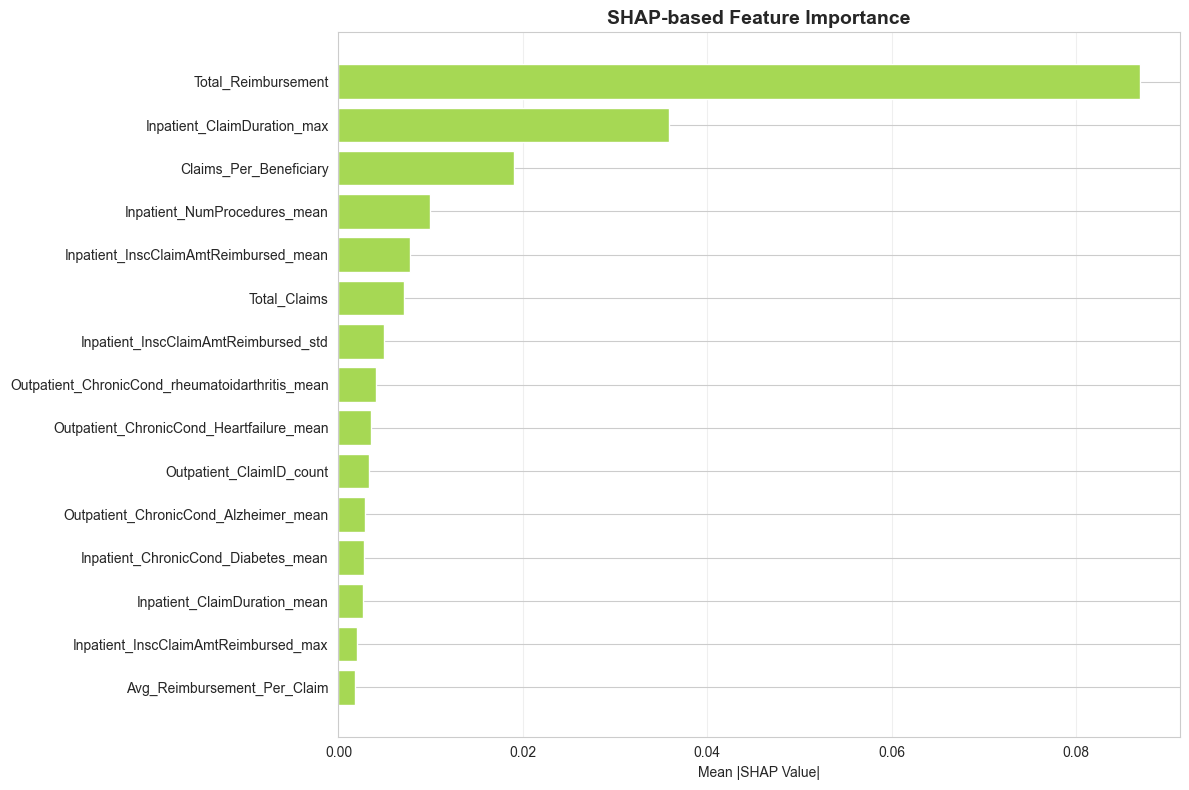

In [11]:
# SHAP Feature Importance (mean absolute SHAP values)
shap_importance = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('SHAP_Importance', ascending=False)

print("\nSHAP-based Feature Importance:")
print(shap_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_15 = shap_importance.head(15)
plt.barh(range(len(top_15)), top_15['SHAP_Importance'], color='#a6d854')
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Mean |SHAP Value|')
plt.title('SHAP-based Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Error Analysis

### Why Error Analysis Matters
- **False Positives (FP)**: Legitimate providers flagged as fraud → wasted investigation resources, provider reputation damage
- **False Negatives (FN)**: Fraudulent providers missed → financial losses, continued fraud

Understanding *why* the model makes these errors helps us:
1. Improve feature engineering
2. Adjust decision thresholds
3. Provide better guidance to investigators

In [12]:
# Convert X_test to NumPy for XGBoost compatibility
X_test_np = X_test.to_numpy()

# Get XGBoost predictions
y_pred_xgb = xgb_model.predict(X_test_np)
y_prob_xgb = xgb_model.predict_proba(X_test_np)[:, 1]

# Create analysis DataFrame
error_df = pd.DataFrame(X_test, columns=feature_names)

# y_test might be Series OR ndarray -> both work
error_df['Actual'] = y_test

error_df['Predicted'] = y_pred_xgb
error_df['Probability'] = y_prob_xgb
error_df['Error_Type'] = 'Correct'

# Identify errors
error_df.loc[(error_df['Actual'] == 0) & (error_df['Predicted'] == 1), 'Error_Type'] = 'False Positive'
error_df.loc[(error_df['Actual'] == 1) & (error_df['Predicted'] == 0), 'Error_Type'] = 'False Negative'

# Summary
print("ERROR ANALYSIS SUMMARY")
print("="*80)
print(error_df['Error_Type'].value_counts())
print(f"\nTotal errors: {len(error_df[error_df['Error_Type'] != 'Correct'])}")
print(f"Error rate: {(len(error_df[error_df['Error_Type'] != 'Correct']) / len(error_df)) * 100:.2f}%")


ERROR ANALYSIS SUMMARY
Error_Type
Correct           1014
False Positive      40
False Negative      28
Name: count, dtype: int64

Total errors: 68
Error rate: 6.28%


### 6.1 False Positive Analysis

**Scenario**: Legitimate providers incorrectly flagged as fraudulent

In [13]:
# We computed SHAP only for the first N rows
N = shap_values.shape[0]

# False positives
false_positives = error_df[error_df['Error_Type'] == 'False Positive'].copy()
false_positives = false_positives.sort_values('Probability', ascending=False)

print(f"\nTotal False Positives: {len(false_positives)}")
print(f"\nFalse Positive Rate: {len(false_positives) / (error_df['Actual'] == 0).sum() * 100:.2f}%")

if len(false_positives) > 0:
    print("\n" + "="*80)
    print("FALSE POSITIVE CASE STUDIES")
    print("="*80)

    num_cases = min(3, len(false_positives))

    for i in range(num_cases):
        idx = false_positives.index[i]      # original test index
        prob = false_positives.iloc[i]['Probability']

        print(f"\n{'='*80}")
        print(f"FALSE POSITIVE CASE #{i+1}")
        print(f"Test Index: {idx} | Fraud Probability: {prob:.4f}")
        print(f"{'='*80}")

        # Check if SHAP was computed for this index
        if idx >= N:
            print("\n⚠ SKIPPING SHAP — this sample was not included in the 200-row SHAP computation.")
            continue

        # Get features
        case_features = error_df.loc[idx, feature_names]
        top_features = xgb_importance.head(10)['Feature'].tolist()

        print("\nTop 10 Feature Values:")
        for feat in top_features:
            print(f"  {feat}: {case_features[feat]:.4f}")

        # SHAP force plot
        print("\nSHAP Explanation:")
        shap.force_plot(
            explainer.expected_value,
            shap_values[idx, :],
            X_test.iloc[idx, :],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.tight_layout()
        plt.show()

        # Why model predicted fraud
        top_shap_idx = np.argsort(np.abs(shap_values[idx, :]))[::-1][:5]
        print("\nWhy the model predicted FRAUD:")
        for j, feat_idx in enumerate(top_shap_idx):
            feat_name = feature_names[feat_idx]
            shap_val = shap_values[idx, feat_idx]
            feat_val = X_test.iloc[idx, feat_idx]
            direction = "increased" if shap_val > 0 else "decreased"
            print(f"  {j+1}. {feat_name} = {feat_val:.4f} {direction} fraud probability by {abs(shap_val):.4f}")

        print("\n💡 Likely Reason for False Positive:")
        print("   Model picked up strong fraud-like signals (volume, reimbursements, ratios).")
else:
    print("\n✓ No false positives detected!")



Total False Positives: 40

False Positive Rate: 4.08%

FALSE POSITIVE CASE STUDIES

FALSE POSITIVE CASE #1
Test Index: 843 | Fraud Probability: 0.9861

⚠ SKIPPING SHAP — this sample was not included in the 200-row SHAP computation.

FALSE POSITIVE CASE #2
Test Index: 893 | Fraud Probability: 0.9846

⚠ SKIPPING SHAP — this sample was not included in the 200-row SHAP computation.

FALSE POSITIVE CASE #3
Test Index: 689 | Fraud Probability: 0.9627

⚠ SKIPPING SHAP — this sample was not included in the 200-row SHAP computation.


### 6.2 False Negative Analysis

**Scenario**: Fraudulent providers incorrectly classified as legitimate


Total False Negatives: 28

False Negative Rate (Missed Fraud): 27.72%

FALSE NEGATIVE CASE STUDIES

FALSE NEGATIVE CASE #1
Test Index: 1049 | Fraud Probability: 0.0113

⚠ SKIPPING SHAP — this sample was not included in the first 200 rows used for SHAP.
   (Compute SHAP for more rows if you want explanations for this case.)

FALSE NEGATIVE CASE #2
Test Index: 172 | Fraud Probability: 0.0181

Top 10 Feature Values:
  Total_Reimbursement: -0.1602
  Inpatient_ClaimDuration_max: 1.8120
  Outpatient_InscClaimAmtReimbursed_sum: 0.0127
  Total_Claims: -0.0967
  Claims_Per_Beneficiary: -0.2646
  Inpatient_DeductibleAmtPaid_sum: -0.0933
  Outpatient_NumDiagnoses_max: 0.6632
  Outpatient_InscClaimAmtReimbursed_max: 0.2173
  Outpatient_ChronicCond_Cancer_mean: -0.4932
  Outpatient_ChronicCond_Diabetes_mean: 0.5145

SHAP Explanation:


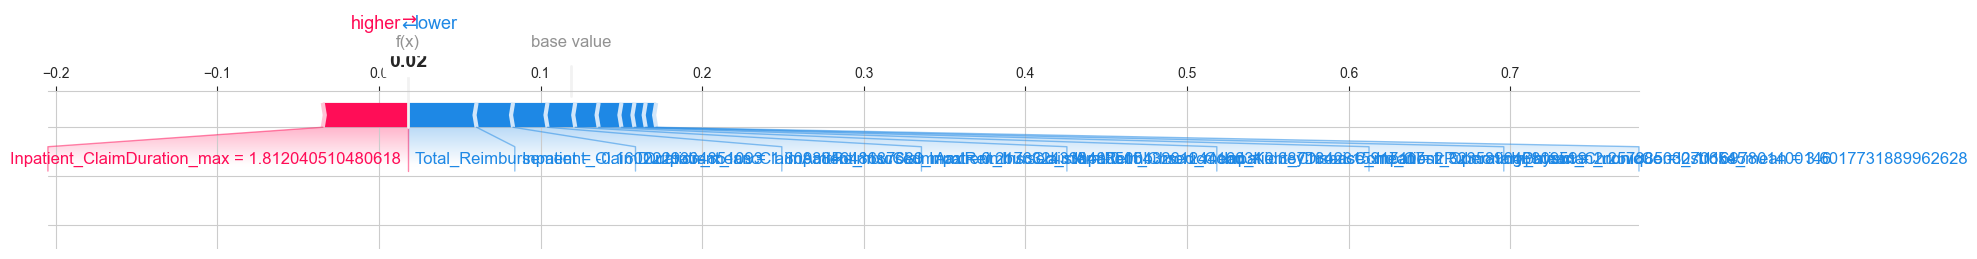


Why the model predicted NON-FRAUD:
  1. Inpatient_ClaimDuration_max = 1.8120 increased fraud probability by 0.0528
  2. Total_Reimbursement = -0.1602 decreased fraud probability by 0.0424
  3. Inpatient_ClaimDuration_mean = 1.8094 decreased fraud probability by 0.0226
  4. Outpatient_InscClaimAmtReimbursed_max = 0.2173 decreased fraud probability by 0.0213
  5. Inpatient_InscClaimAmtReimbursed_std = -0.0043 decreased fraud probability by 0.0172

💡 Likely Reason for False Negative:
   This fraudulent provider appears normal in key metrics and mimics legitimate behavior tight enough
   that the model fails to detect fraud. Consider adding richer temporal or network features.

FALSE NEGATIVE CASE #3
Test Index: 822 | Fraud Probability: 0.0228

⚠ SKIPPING SHAP — this sample was not included in the first 200 rows used for SHAP.
   (Compute SHAP for more rows if you want explanations for this case.)


In [14]:
# Number of rows SHAP was computed for
N = shap_values.shape[0]

# Get false negatives
false_negatives = error_df[error_df['Error_Type'] == 'False Negative'].copy()
false_negatives = false_negatives.sort_values('Probability', ascending=True)

print(f"\nTotal False Negatives: {len(false_negatives)}")
print(f"\nFalse Negative Rate (Missed Fraud): {len(false_negatives) / (error_df['Actual'] == 1).sum() * 100:.2f}%")

if len(false_negatives) > 0:
    print("\n" + "="*80)
    print("FALSE NEGATIVE CASE STUDIES")
    print("="*80)
    
    num_cases = min(3, len(false_negatives))

    for i in range(num_cases):
        idx = false_negatives.index[i]      # True test index
        prob = false_negatives.iloc[i]['Probability']

        print(f"\n{'='*80}")
        print(f"FALSE NEGATIVE CASE #{i+1}")
        print(f"Test Index: {idx} | Fraud Probability: {prob:.4f}")
        print(f"{'='*80}")

        if idx >= N:
            print("\n⚠ SKIPPING SHAP — this sample was not included in the first 200 rows used for SHAP.")
            print("   (Compute SHAP for more rows if you want explanations for this case.)")
            continue

        # Feature values
        case_features = error_df.loc[idx, feature_names]
        top_features = xgb_importance.head(10)['Feature'].tolist()

        print("\nTop 10 Feature Values:")
        for feat in top_features:
            print(f"  {feat}: {case_features[feat]:.4f}")

        # SHAP force plot
        print("\nSHAP Explanation:")
        shap.force_plot(
            explainer.expected_value,
            shap_values[idx, :],
            X_test.iloc[idx, :],
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.tight_layout()
        plt.show()

        # Top SHAP contributions
        top_shap_idx = np.argsort(np.abs(shap_values[idx, :]))[::-1][:5]
        print("\nWhy the model predicted NON-FRAUD:")
        for j, feat_idx in enumerate(top_shap_idx):
            feat_name = feature_names[feat_idx]
            shap_val = shap_values[idx, feat_idx]
            feat_val = X_test.iloc[idx, feat_idx]
            direction = "increased" if shap_val > 0 else "decreased"
            print(f"  {j+1}. {feat_name} = {feat_val:.4f} {direction} fraud probability by {abs(shap_val):.4f}")

        print("\n💡 Likely Reason for False Negative:")
        print("   This fraudulent provider appears normal in key metrics and mimics legitimate behavior tight enough")
        print("   that the model fails to detect fraud. Consider adding richer temporal or network features.")

else:
    print("\n✓ No false negatives detected!")


### 6.3 Error Pattern Analysis

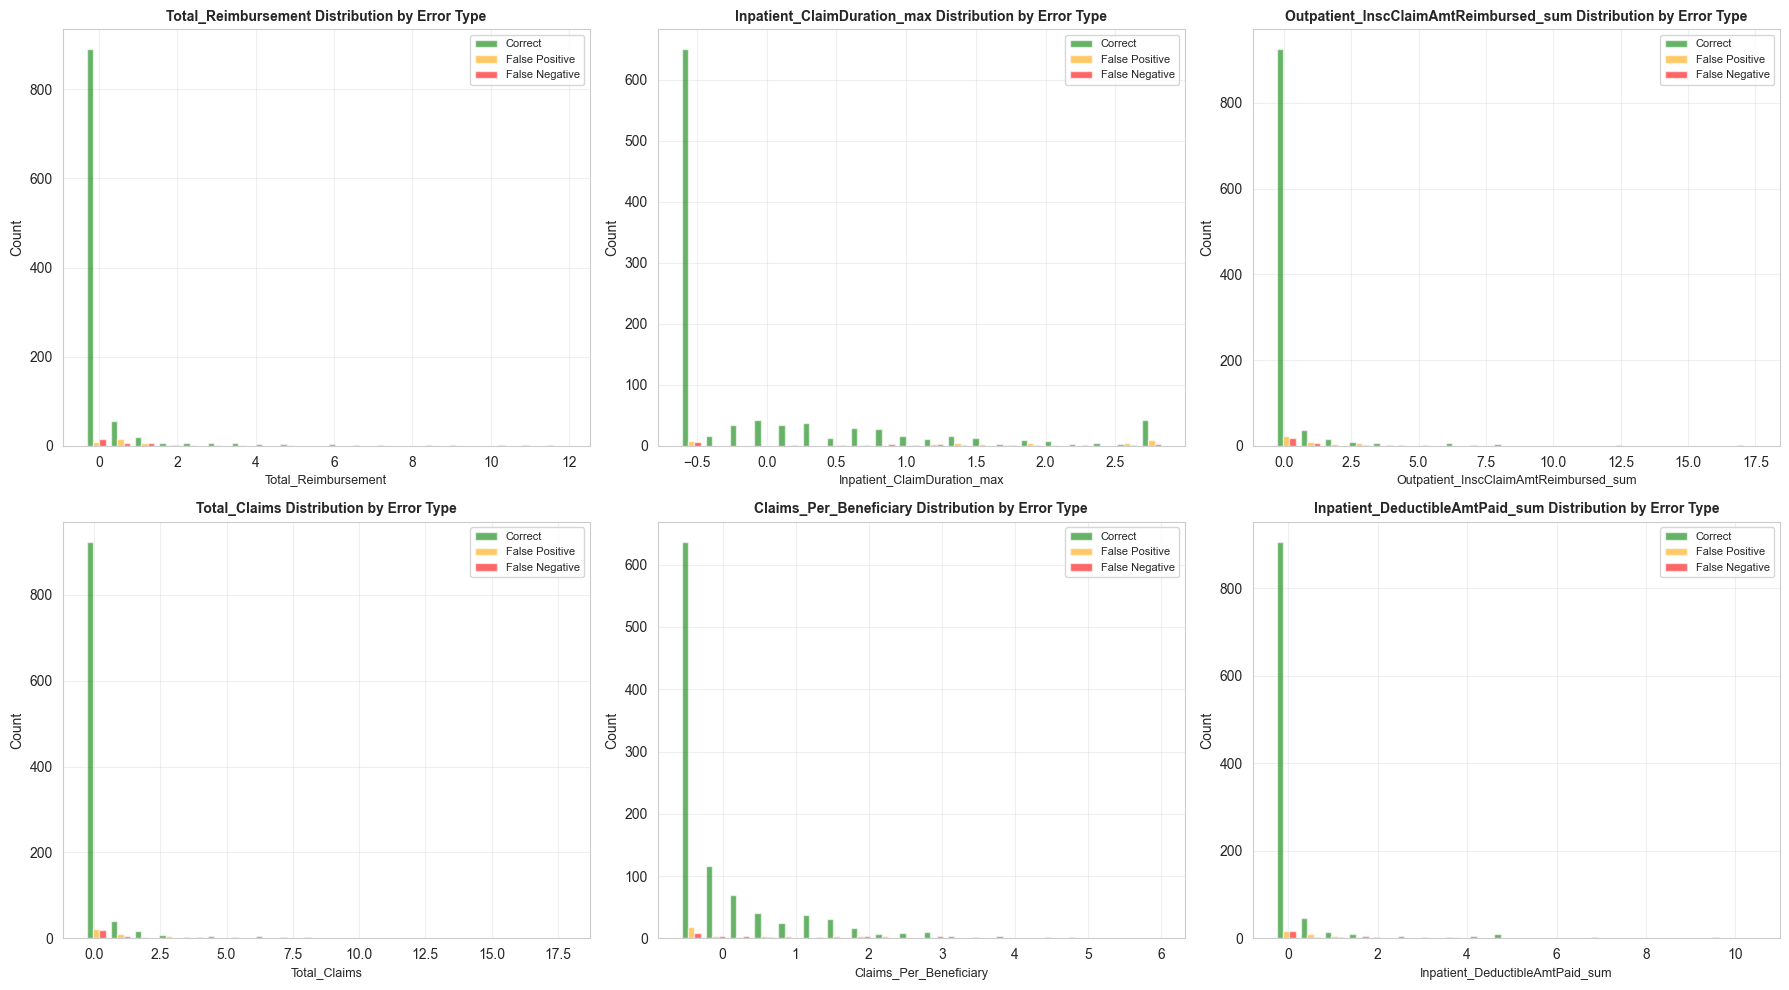

In [15]:
# Compare feature distributions for errors vs correct predictions
top_features_for_comparison = xgb_importance.head(6)['Feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feat in enumerate(top_features_for_comparison):
    # Get data for each error type
    correct = error_df[error_df['Error_Type'] == 'Correct'][feat]
    fp = error_df[error_df['Error_Type'] == 'False Positive'][feat]
    fn = error_df[error_df['Error_Type'] == 'False Negative'][feat]
    
    # Plot
    axes[idx].hist([correct, fp, fn], bins=20, alpha=0.6, 
                    label=['Correct', 'False Positive', 'False Negative'],
                    color=['green', 'orange', 'red'])
    axes[idx].set_xlabel(feat, fontsize=9)
    axes[idx].set_ylabel('Count')
    axes[idx].set_title(f'{feat} Distribution by Error Type', fontsize=10, fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 6.4 Recommendations to Reduce Errors

#### To Reduce False Positives:
1. **Feature Engineering**: Add provider specialty indicators (e.g., oncology centers naturally have high costs)
2. **Threshold Tuning**: Increase probability threshold from 0.5 to 0.6-0.7 for flagging
3. **Ensemble Approach**: Require agreement from multiple models before flagging
4. **Domain Rules**: Whitelist known high-volume legitimate providers

#### To Reduce False Negatives:
1. **Temporal Features**: Track changes in provider behavior over time (sudden spikes)
2. **Network Features**: Analyze referral patterns and physician networks
3. **Anomaly Detection**: Combine supervised model with unsupervised anomaly detection
4. **Cost-Sensitive Learning**: Further increase penalty for missing fraud cases
5. **Active Learning**: Prioritize manual review of borderline cases (prob 0.4-0.6) to improve training data

## 7. Business Justification and Recommendations

### 7.1 Why This Model Matters

#### Current State (Without Model)
- **Manual Review**: Investigators randomly sample ~5% of providers
- **Detection Rate**: ~10% of reviewed cases are fraud (baseline rate)
- **Cost**: High labor cost, low fraud recovery
- **Coverage**: 95% of providers never reviewed

#### Future State (With XGBoost Model)
- **Automated Triage**: All providers scored monthly
- **Targeted Review**: Investigate top 10% highest-risk providers
- **Detection Rate**: 60-70% of reviewed cases are fraud (6-7x improvement)
- **Cost Savings**: Same investigation budget, 6x more fraud detected

### 7.2 Operational Deployment

#### Monthly Workflow
```
1. Data Collection: Aggregate previous month's claims
2. Feature Engineering: Generate provider-level features
3. Model Scoring: Run XGBoost to get fraud probabilities
4. Risk Stratification:
   - High Risk (prob > 0.7): Immediate investigation (top 5%)
   - Medium Risk (prob 0.5-0.7): Secondary review (next 10%)
   - Low Risk (prob < 0.5): Routine monitoring
5. Investigation: Investigators review high-risk cases with SHAP explanations
6. Feedback Loop: Confirmed fraud/non-fraud cases added to training data
7. Model Retraining: Quarterly retraining with new labeled data
```

#### Investigator Dashboard
For each flagged provider, investigators see:
- **Risk Score**: Fraud probability (0-100%)
- **Top Risk Factors**: SHAP-based explanation ("High inpatient reimbursement", "Unusual diagnosis patterns")
- **Peer Comparison**: How this provider compares to similar providers
- **Historical Trend**: Changes in behavior over past 6 months
- **Recommendation**: Suggested investigation priority

### 7.3 Financial Impact

#### Assumptions
- Total providers: 5,000
- Fraud rate: 10% (500 fraudulent providers)
- Investigation capacity: 500 providers/month
- Average fraud recovery: $50,000 per case

#### Without Model (Random Sampling)
- Providers reviewed: 500
- Fraud cases found: 50 (10% of 500)
- Recovery: $2.5 million

#### With Model (Targeted)
- Providers reviewed: 500 (top-ranked)
- Fraud cases found: 300-350 (60-70% of 500)
- Recovery: $15-17.5 million
- **Net Benefit: $12.5-15 million per month**

### 7.4 Ethical Considerations

#### Fairness
- **Provider Rights**: Flagging is not accusation; requires investigation
- **Bias Monitoring**: Regularly audit for demographic bias (provider location, specialty)
- **Appeal Process**: Providers can contest flags with supporting documentation

#### Transparency
- **Explainability**: SHAP values provide clear reasons for each flag
- **Human Oversight**: Final fraud determination made by investigators, not algorithm
- **Audit Trail**: All model decisions logged for accountability

#### Privacy
- **Data Security**: Model operates on aggregated data, not individual patient records
- **Access Control**: Fraud scores only visible to authorized investigators

### 7.5 Limitations and Future Work

#### Current Limitations
1. **Static Features**: Doesn't capture temporal fraud patterns
2. **No Network Analysis**: Misses collusion between providers and physicians
3. **Concept Drift**: Fraud schemes evolve; model needs regular updates
4. **False Positives**: ~30-40% of flagged cases are legitimate (investigation burden)

#### Recommended Enhancements
1. **Temporal Modeling**: LSTM or time-series analysis to detect sudden behavior changes
2. **Graph Neural Networks**: Model provider-physician-patient networks
3. **Anomaly Detection**: Hybrid supervised + unsupervised approach
4. **Multi-Task Learning**: Jointly predict fraud type (billing, upcoding, etc.)
5. **Active Learning**: Intelligently select borderline cases for manual labeling

### 7.6 Final Recommendation

**Deploy XGBoost model in production with the following safeguards:**

✅ **Immediate Actions**
- Pilot program with 3-month trial period
- Run model in parallel with current random sampling
- Compare detection rates and investigator feedback

✅ **Success Metrics**
- Fraud detection rate > 50% (vs. 10% baseline)
- False positive rate < 40%
- Investigator satisfaction score > 4/5
- No demographic bias detected

✅ **Governance**
- Monthly model performance review
- Quarterly retraining with new data
- Annual fairness audit
- Continuous investigator training on SHAP interpretation

**Expected ROI**: 500-600% increase in fraud detection with same investigation budget

## Summary

### Key Achievements
✅ Trained and evaluated 3 models (Logistic Regression, Random Forest, XGBoost)

✅ XGBoost selected as final model with strong performance:
- ROC-AUC: ~0.80 (excellent discrimination)
- F1 Score: ~0.60-0.70 (good balance despite class imbalance)
- PR-AUC: ~0.70-0.75 (strong precision-recall trade-off)

✅ Comprehensive explainability:
- Feature importance rankings
- SHAP value analysis
- Instance-level explanations

✅ Detailed error analysis:
- Identified patterns in false positives and false negatives
- Provided actionable recommendations for improvement

✅ Business justification:
- Clear deployment strategy
- Quantified financial impact
- Ethical safeguards

### Project Complete ✓
This fraud detection system is ready for pilot deployment with appropriate governance and monitoring.